In [78]:
import pandas as pd

df = pd.read_csv("dataset_mood_smartphone.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376912 entries, 0 to 376911
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  376912 non-null  int64  
 1   id          376912 non-null  object 
 2   time        376912 non-null  object 
 3   variable    376912 non-null  object 
 4   value       376710 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.4+ MB


In [79]:
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.drop("Unnamed: 0", axis=1)
    df['time'] = pd.to_datetime(df["time"])
    
    var_names = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen',
                 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
                 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
                 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

    user_ids = ['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07', 'AS14.08',
           'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15', 'AS14.16', 'AS14.17',
           'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24', 'AS14.25', 'AS14.26', 'AS14.27',
           'AS14.28', 'AS14.29', 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']


    # helper to concat dfs grouped by var name
    df_out = pd.DataFrame()

    # group by variable type
    for name in var_names:
        df_var_tmp = df[df['variable'] == name]

        # helper to concat dfs grouped by id
        df_var = pd.DataFrame()

        # group by user id
        for id in user_ids:
            df_id_tmp = df_var_tmp[df_var_tmp['id'] == id]

            # remove missing values
            df_id_tmp = df_id_tmp[df_id_tmp['value'].notna()]

            # drop values outside the range

            # 1 to 10
            if name == "mood":
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= 1) & (df_id_tmp['value'] <= 10)]
            # 0 to 1
            elif name == "activity":
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= 0) & (df_id_tmp['value'] <= 1)]
            # -2 to 2
            elif name in ['circumplex.arousal', 'circumplex.valence']:
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= -2) & (df_id_tmp['value'] <= 2)]
            # 1
            elif name in ['sms', 'call']:
                df_id_tmp = df_id_tmp[df_id_tmp['value'] == 1]
            # else is time data, so > 0
            else:
                df_id_tmp = df_id_tmp[df_id_tmp['value'] >= 0]

            # remove outliers bellow 01 quantile and above 99 quantile
            lower = df_id_tmp['value'].quantile(.01)
            upper = df_id_tmp['value'].quantile(.99)

            # outliers replaced with lower and upper value respectively
            df_id_tmp['value'] = df_id_tmp['value'].clip(lower=lower, upper=upper)

            # drop duplicates with the exact same date by taking a mean of them
            df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'], df_id_tmp['variable']])['value'].mean().reset_index()

            # grouping by day
            if name in ['mood', 'circumplex.arousal', 'circumplex.valence']:
                df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'].dt.date, df_id_tmp['variable']])['value'].mean().reset_index()
            else:
                df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'].dt.date, df_id_tmp['variable']])['value'].sum().reset_index()

            # concat df
            df_var = pd.concat([df_var, df_id_tmp])

        # concat df
        df_out = pd.concat([df_out, df_var])
    
    df_out.sort_values(by = ['id', 'time'], inplace=True)
    
    df_out.reset_index(drop=True, inplace=True)
    
    return df_out

df_clean = clean_dataset(df)
df_clean.head()

,id,time,variable,value
0,AS14.01,2014-02-17,call,2.0
1,AS14.01,2014-02-18,call,1.0
2,AS14.01,2014-02-19,call,7.0
3,AS14.01,2014-02-19,sms,2.0
4,AS14.01,2014-02-20,call,2.0


In [92]:
def pivot_to_wide(df: pd.DataFrame) -> pd.DataFrame:
    return pd.pivot(df, index=['id','time'], columns='variable', values = 'value').reset_index()
    
wide = pivot_to_wide(df_clean)
wide.tail()

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
1968,AS14.33,2014-05-27,0.304902,555.85736,2078.40300,124.694,NaN,NaN,NaN,142.6860,...,NaN,NaN,56.17400,NaN,1.0,-0.600000,0.4,6.2,4089.879001,2.0
1969,AS14.33,2014-05-28,2.479228,2310.27220,1936.88728,614.706,NaN,NaN,351.86132,519.0175,...,NaN,NaN,30.66600,NaN,10.0,0.000000,1.2,8.2,12718.706198,1.0
1970,AS14.33,2014-05-29,4.064507,400.03400,435.10500,136.738,NaN,NaN,NaN,29.2020,...,0.939,NaN,3.19900,NaN,5.0,-1.333333,1.0,7.0,3440.799000,1.0
1971,AS14.33,2014-05-30,4.041369,2566.80988,1670.84200,260.220,NaN,NaN,NaN,52.6100,...,1052.648,8.13206,213.73936,NaN,4.0,-0.800000,-0.4,6.8,9497.646999,NaN
1972,AS14.33,2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.000000,1.0,7.0,NaN,NaN


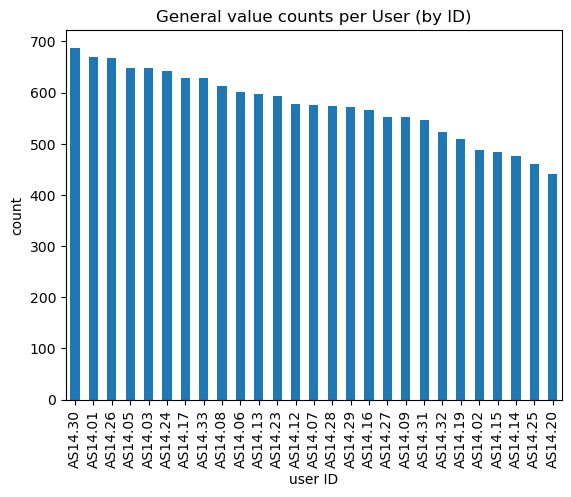

In [80]:
import matplotlib.pyplot as plt
df_clean.id.value_counts().plot(kind="bar")
plt.title("General value counts per User (by ID)")
plt.xlabel("user ID")
plt.ylabel("count")
plt.show()

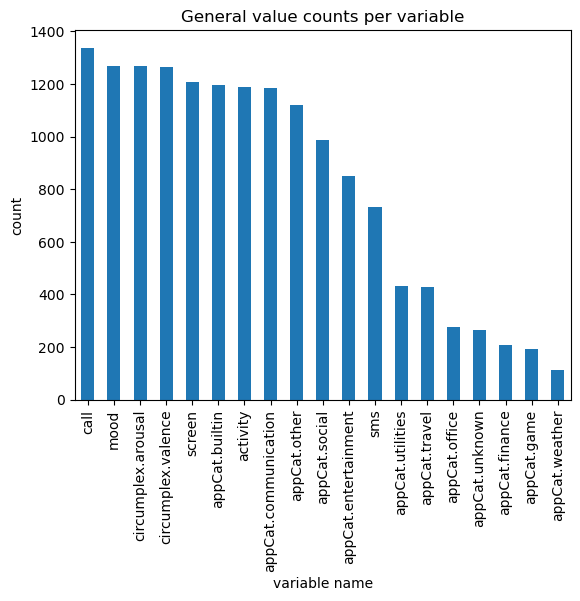

In [81]:
df_clean.variable.value_counts().plot(kind="bar")
plt.title("General value counts per variable")
plt.xlabel("variable name")
plt.ylabel("count")
plt.show()

#### Plot timeseries function

can be used to plot all of the time series scatter plots at once
- y axis: values of a given variable
- x axis: time

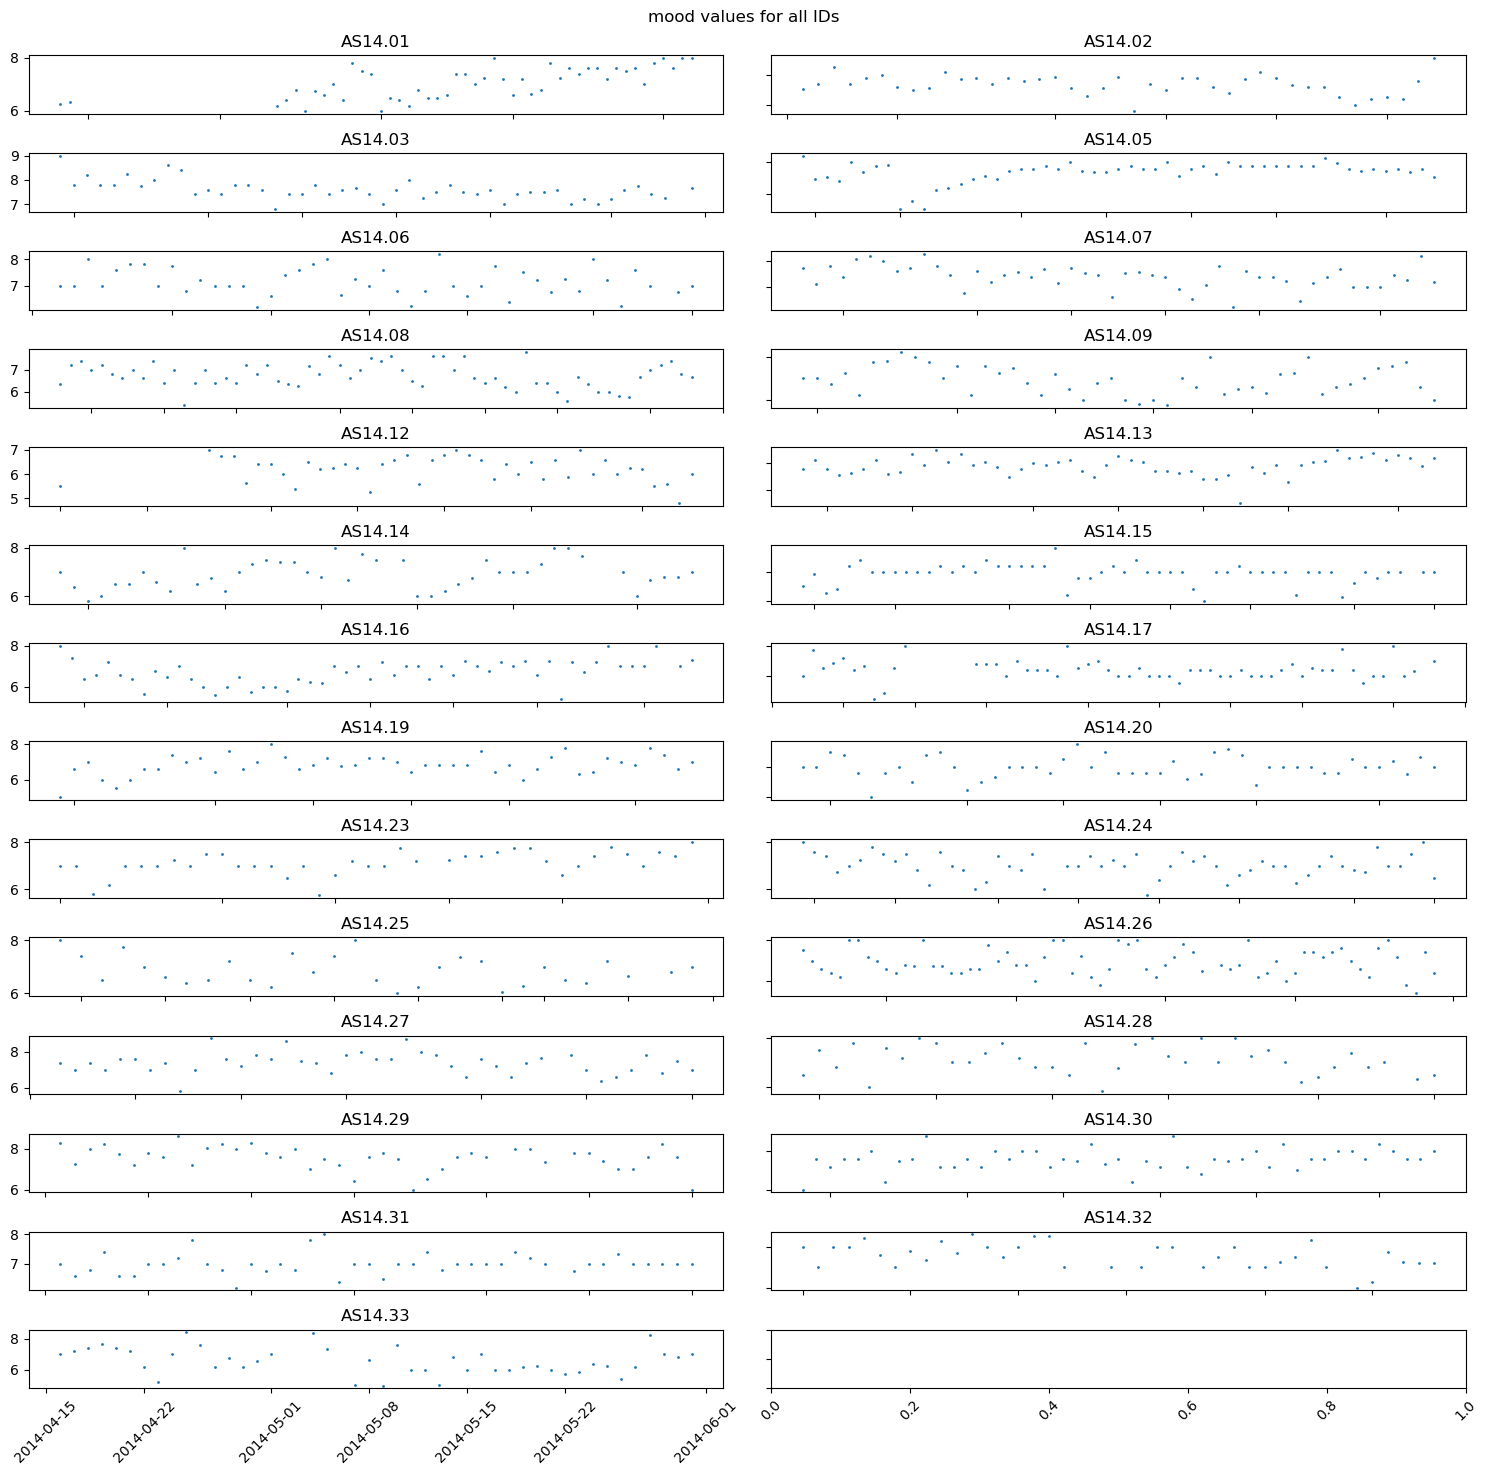

In [83]:
def plot_timeseries(df: pd.DataFrame, variable: str) -> None:
    df = df[df['variable'] == variable]
    id_data = []
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        id_data.append((id_df['time'], id_df['value'], id))
        
    vertical_axs = 14 # because we have 27 ids in total, 2 per row
    fig, axs = plt.subplots(vertical_axs, 2)
    
    for x in range(vertical_axs):
        id_1 = 2*x
        id_2 = id_1 + 1
        
        # left subplot in a row
        if(id_1 < len(id_data)):
            axs[x, 0].plot_date(id_data[id_1][0], id_data[id_1][1], markersize=1)
            axs[x, 0].set_title(id_data[id_1][2])
        
        # right subplot in a row
        if(id_2 < len(id_data)):
            axs[x, 1].plot_date(id_data[id_2][0], id_data[id_2][1], markersize=1)
            axs[x, 1].set_title(id_data[id_2][2])
    
    for ax in fig.get_axes():
        # only outer labels
        ax.label_outer()
        # rotate labels for timeseries data
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{variable} values for all IDs")
    

plot_timeseries(df_clean, "mood")

to plot a bigger single plot for a given id

Text(0.5, 1.0, 'AS14.01 mood')

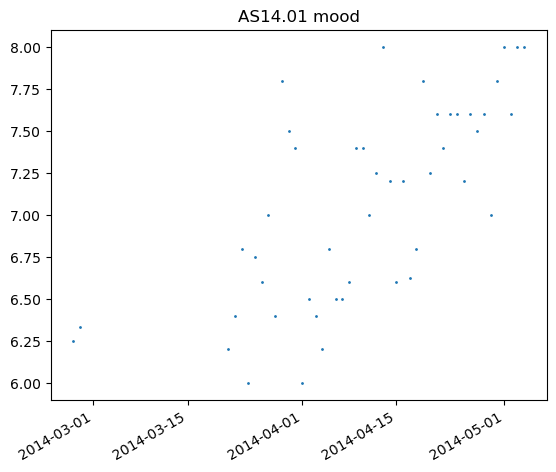

In [87]:
variable = 'mood'
id = 'AS14.01'
df_1 = df_clean[df_clean['variable'] == variable]
df_1 = df_1[df_1['id'] == id]
plt.plot_date(df_1['time'], df_1['value'], markersize=1)
plt.xticks(rotation=30, ha='right')
plt.title(f"{id} {variable}")

In [88]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_clean, title="Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]